# Where to Live in Wellington, NZ?
*By Shaun Wesley Que*

## I. Introduction

### A. Background

New Zealand's early success in crushing the curve of the coronavirus disease 2019 (COVID-19) has made waves all over the world. By July 2, 2020, New Zealand has recorded 1,180 confirmed cases of COVID-19 with only 22 deaths since its first case on February 28. The country's Director-General of Health Dr. Ashley Bloomfield said that their strategy is based on speedy testing, contract tracing and isolation, and rigorously adhering to public health guidance ([WHO](https://www.who.int/westernpacific/news/feature-stories/detail/new-zealand-takes-early-and-hard-action-to-tackle-covid-19)). Despite similar measures being enforced in other countries, the results are quite the opposite. People are generally faulting their respective governments for ineffectively handling the current crisis, and are looking at options on how not to experience this "government failure" all over again should another unprecedented crisis hit. 

### B. Target Audience

Since the coronavirus pandemic took hold this year, more than 250,000 Americans have investigated whether they qualify to move to New Zealand. In June alone, 112,800 more Americans visited New Zealand's immigration website compared to same time last year. This is a 160% spike and is equivalent to one American clicking on the site every 30 seconds ([NZ Herald](https://www.nzherald.co.nz/nz/news/article.cfm?c_id=1&objectid=12351693&utm_source=fark&utm_medium=website&utm_content=link&ICID=ref_fark)). Given the comparative statistics between the two countries, this general sentiment is not surprising. 

### C. Business Problem

This report aims to help people who are looking to move to New Zealand's capital, Wellington, to decide which urban district to move into based on the cost, population, and general closest venues of relevance (supermarkets, restaurants, parks, etc.), among other factors. 

## II. Data Preparation

* **List of Urban Areas and Population** 
    - Source: [Wikipedia](https://en.wikipedia.org/wiki/Wellington_Region)
    - Description: This is the masterlist of the urban areas in Wellington, with their corresponding population
    - Example: Wellington, Lower Hutt, Porirua, Upper Hutt, Paraparamu
* **Median Housing Price** 
    - Source: [Real Estate Investar NZ](https://www.realestateinvestar.co.nz/)
    - Description: The median housing price data here is used to compare how expensive property prices are across the districts.
    - Example: Wellington: 870K, Lower Hutt: 660K, Porirua: 850K, Upper Hutt: 662.5K
* **Nearby Venues of Interest** 
    - Source: [Foursquare API](https://developer.foursquare.com/)
    - Description: This is used to identify the closest venues for relevance.
    - Example: supermarkets, restaurants, parks

### A. Create District, Population, Price, and Geocoordinate dataframe

In [1]:
# Import libraries

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim 
import seaborn as sns

#conda install -c conda-forge folium
#conda install -c conda-forge geopy

In [2]:
# Read and Merge Data
district = pd.read_csv('WellingtonDistrict.csv')
prices = pd.read_csv('WellingtonMedianPrices.csv')

df = pd.merge(district, prices, left_on="District", right_on="District")
df.Population = pd.to_numeric(df.Population)
df.MedianPrice = pd.to_numeric(df.MedianPrice)
df['Latitude'] = ""
df['Longitude'] = ""
df

,District,Population,MedianPrice,Latitude,Longitude
0,Wellington,215400,870000,,
1,Lower Hutt,104900,660000,,
2,Porirua,55500,850000,,
3,Upper Hutt,41000,662500,,
4,Paraparaumu,28900,655000,,
5,Masterton,20100,447000,,
6,Waikanae,12100,655000,,
7,Carterton,5390,495000,,
8,Otaki,4490,655000,,
9,Featherston,2480,555000,,


In [3]:
# Get Latitude and Longitude
geolocator = Nominatim(user_agent="ny_explorer")

for i in range(len(df)):
    location = geolocator.geocode(df.District[i] + ', Wellington, New Zealand')
    df.Latitude[i] = location.latitude
    df.Longitude[i] = location.longitude  

<ipython-input-3-c0966df265d2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Latitude[i] = location.latitude
<ipython-input-3-c0966df265d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Longitude[i] = location.longitude


In [4]:
df

,District,Population,MedianPrice,Latitude,Longitude
0,Wellington,215400,870000,-41.2888,174.777
1,Lower Hutt,104900,660000,-41.2126,174.906
2,Porirua,55500,850000,-41.1355,174.84
3,Upper Hutt,41000,662500,-41.1241,175.07
4,Paraparaumu,28900,655000,-40.9145,175.006
5,Masterton,20100,447000,-40.9496,175.659
6,Waikanae,12100,655000,-40.8758,175.064
7,Carterton,5390,495000,-41.0243,175.526
8,Otaki,4490,655000,-40.7549,175.151
9,Featherston,2480,555000,-41.1149,175.325


### B. Cluster Wellington's Districts

In [5]:
# Define Foursquare credentials and version
CLIENT_ID = 'XN0PQCXD515RNM4LRAPP0HQ5FN1NU41JRSE1XYAH40IJ1VM3'
CLIENT_SECRET = '0AG5FCPT5KD00TNYLJQ0GTDZOVMARADUJGXP1SMQHQME1P0A'
VERSION = '20180605'

In [6]:
# Define Get Nearby Venues Function
def getNearbyVenues(names, latitudes, longitudes):
    radius = 500
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
# Run the function on each neighborhood
wellington_venues = getNearbyVenues(names=df.District,
                                   latitudes=df.Latitude,
                                   longitudes=df.Longitude
                                  )

Wellington
Lower Hutt
Porirua
Upper Hutt
Paraparaumu
Masterton
Waikanae
Carterton
Otaki
Featherston
Greytown
Paekakariki
Otaki Beach
Martinborough


In [8]:
# Check size of resulting dataframe
wellington_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wellington,-41.288795,174.777211,Lamason,-41.289843,174.776001,Coffee Shop
1,Wellington,-41.288795,174.777211,Wellington Waterfront,-41.288074,174.779528,Waterfront
2,Wellington,-41.288795,174.777211,Nikau Gallery Cafe,-41.288483,174.777578,Café
3,Wellington,-41.288795,174.777211,Tatsushi,-41.289690,174.775691,Japanese Restaurant
4,Wellington,-41.288795,174.777211,Fork & Brewer,-41.289270,174.775769,Gastropub


In [9]:
# Check shape of resulting dataframe
wellington_venues.shape

(191, 7)

In [10]:
# How many venues were returned for each neighborhood
wellington_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Carterton,4,4,4,4,4,4
Featherston,6,6,6,6,6,6
Greytown,8,8,8,8,8,8
Lower Hutt,21,21,21,21,21,21
Martinborough,16,16,16,16,16,16
Masterton,10,10,10,10,10,10
Otaki,3,3,3,3,3,3
Otaki Beach,5,5,5,5,5,5
Paekakariki,2,2,2,2,2,2


In [11]:
# How many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(wellington_venues['Venue Category'].unique())))

There are 80 uniques categories.


## III. Methodology 

### A. Analyze Each Neighborhood

In [12]:
# one hot encoding
wellington_onehot = pd.get_dummies(wellington_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
wellington_onehot['Neighborhood'] = wellington_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [wellington_onehot.columns[-1]] + list(wellington_onehot.columns[:-1])
wellington_onehot = wellington_onehot[fixed_columns]

wellington_onehot.head()

,Neighborhood,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,...,Snack Place,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Tourist Information Center,Train Station,Vietnamese Restaurant,Waterfront,Wine Shop
0,Wellington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wellington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Wellington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wellington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wellington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Examine the new dataframe size.
wellington_onehot.shape

(191, 81)

In [14]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
wellington_grouped = wellington_onehot.groupby('Neighborhood').mean().reset_index()
wellington_grouped

,Neighborhood,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,...,Snack Place,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Tourist Information Center,Train Station,Vietnamese Restaurant,Waterfront,Wine Shop
0,Carterton,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.0000,0.250000,0.00,0.00,0.0000
1,Featherston,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.0000,0.166667,0.00,0.00,0.0000
2,Greytown,0.00,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.0000,0.000000,0.00,0.00,0.0000
3,Lower Hutt,0.00,0.047619,0.000000,0.000000,0.000000,0.000000,0.047619,0.000,0.000000,...,0.00,0.095238,0.047619,0.000000,0.00,0.0000,0.000000,0.00,0.00,0.0000
4,Martinborough,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.00,0.062500,0.000000,0.062500,0.00,0.0625,0.000000,0.00,0.00,0.0625
5,Masterton,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100,0.000000,...,0.00,0.100000,0.000000,0.000000,0.00,0.0000,0.000000,0.00,0.00,0.0000
6,Otaki,0.00,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.0000,0.000000,0.00,0.00,0.0000
7,Otaki Beach,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.0000,0.000000,0.00,0.00,0.0000
8,Paekakariki,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.0000,0.500000,0.00,0.00,0.0000
9,Paraparaumu,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.111111,...,0.00,0.111111,0.000000,0.000000,0.00,0.0000,0.000000,0.00,0.00,0.0000


In [15]:
# Confirm the new size
wellington_grouped.shape

(14, 81)

In [16]:
# Print each neighborhood along with the top 5 most common venues

num_top_venues = 5

for hood in wellington_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = wellington_grouped[wellington_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Carterton----
                   venue  freq
0             Playground  0.25
1          Train Station  0.25
2                   Café  0.25
3          Grocery Store  0.25
4  Vietnamese Restaurant  0.00


----Featherston----
           venue  freq
0    Cheese Shop  0.17
1  Deli / Bodega  0.17
2  Grocery Store  0.17
3           Café  0.17
4    Beer Garden  0.17


----Greytown----
                 venue  freq
0                 Café  0.25
1  Arts & Crafts Store  0.12
2        Grocery Store  0.12
3            Hotel Bar  0.12
4               Bakery  0.12


----Lower Hutt----
               venue  freq
0               Café  0.19
1        Supermarket  0.10
2        Coffee Shop  0.10
3      Shopping Mall  0.05
4  Electronics Store  0.05


----Martinborough----
           venue  freq
0           Café  0.25
1          Hotel  0.12
2      Wine Shop  0.06
3          Diner  0.06
4  Grocery Store  0.06


----Masterton----
                        venue  freq
0                        Café   0.5
1     

In [17]:
# Put into a pandas df

# Write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


# Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = wellington_grouped['Neighborhood']

for ind in np.arange(wellington_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wellington_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carterton,Café,Train Station,Playground,Grocery Store,Creperie,Cheese Shop,Chinese Restaurant,Chocolate Shop,Coffee Shop,Convenience Store
1,Featherston,Cheese Shop,Deli / Bodega,Train Station,Café,Grocery Store,Beer Garden,Chinese Restaurant,Chocolate Shop,Coffee Shop,Convenience Store
2,Greytown,Café,Restaurant,Arts & Crafts Store,Grocery Store,Bakery,Hotel Bar,Deli / Bodega,Wine Shop,Chocolate Shop,Coffee Shop
3,Lower Hutt,Café,Coffee Shop,Supermarket,Japanese Restaurant,Plaza,Portuguese Restaurant,Fast Food Restaurant,Mobile Phone Shop,Sandwich Place,Shopping Mall
4,Martinborough,Café,Hotel,Supermarket,Fish & Chips Shop,Plaza,Indie Movie Theater,Deli / Bodega,Grocery Store,Wine Shop,Diner


### B. Cluster Neighborhoods

In [18]:
# set number of clusters
kclusters = 5

wellington_grouped_clustering = wellington_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(wellington_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 1, 1, 1, 1, 4, 0, 2, 1])

In [19]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

wellington_merged = df

# merge wellington_grouped with wellington_data to add latitude/longitude for each neighborhood
wellington_merged = wellington_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')

wellington_merged.head() # check the last columns!

,District,Population,MedianPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wellington,215400,870000,-41.2888,174.777,1,Café,Coffee Shop,Restaurant,Vietnamese Restaurant,Burger Joint,Plaza,Beer Bar,Chinese Restaurant,Art Gallery,Cambodian Restaurant
1,Lower Hutt,104900,660000,-41.2126,174.906,1,Café,Coffee Shop,Supermarket,Japanese Restaurant,Plaza,Portuguese Restaurant,Fast Food Restaurant,Mobile Phone Shop,Sandwich Place,Shopping Mall
2,Porirua,55500,850000,-41.1355,174.84,1,Café,Grocery Store,Gas Station,Portuguese Restaurant,Burger Joint,Men's Store,Mobile Phone Shop,Gym,Movie Theater,Noodle House
3,Upper Hutt,41000,662500,-41.1241,175.07,1,Fast Food Restaurant,Café,Supermarket,Pool,Department Store,Furniture / Home Store,Coffee Shop,Indian Restaurant,Mobile Phone Shop,Burger Joint
4,Paraparaumu,28900,655000,-40.9145,175.006,1,Grocery Store,Movie Theater,Fast Food Restaurant,Coffee Shop,Supermarket,Bar,Pool,Bookstore,Wine Shop,Cosmetics Shop


In [20]:
# initialize
address = 'Featherston, New Zealand' # for map viewing purposes

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Wellington are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(wellington_merged['Latitude'], wellington_merged['Longitude'], wellington_merged['District'], wellington_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Wellington are -41.114939, 175.32524.


### C. Examine Each Cluster

In [21]:
# Cluster 1: Beach
wellington_merged.loc[wellington_merged['Cluster Labels'] == 0, wellington_merged.columns[[1] + list(range(5, wellington_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,1780,0,Beach,Food Truck,Coffee Shop,Bistro,Campground,Deli / Bodega,Chinese Restaurant,Chocolate Shop,Convenience Store,Cosmetics Shop


In [22]:
# Cluster 2: Cafe
wellington_merged.loc[wellington_merged['Cluster Labels'] == 1, wellington_merged.columns[[1] + list(range(5, wellington_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,215400,1,Café,Coffee Shop,Restaurant,Vietnamese Restaurant,Burger Joint,Plaza,Beer Bar,Chinese Restaurant,Art Gallery,Cambodian Restaurant
1,104900,1,Café,Coffee Shop,Supermarket,Japanese Restaurant,Plaza,Portuguese Restaurant,Fast Food Restaurant,Mobile Phone Shop,Sandwich Place,Shopping Mall
2,55500,1,Café,Grocery Store,Gas Station,Portuguese Restaurant,Burger Joint,Men's Store,Mobile Phone Shop,Gym,Movie Theater,Noodle House
3,41000,1,Fast Food Restaurant,Café,Supermarket,Pool,Department Store,Furniture / Home Store,Coffee Shop,Indian Restaurant,Mobile Phone Shop,Burger Joint
4,28900,1,Grocery Store,Movie Theater,Fast Food Restaurant,Coffee Shop,Supermarket,Bar,Pool,Bookstore,Wine Shop,Cosmetics Shop
5,20100,1,Café,Modern European Restaurant,History Museum,Supermarket,Bakery,Sandwich Place,Wine Shop,Creperie,Chinese Restaurant,Chocolate Shop
10,2420,1,Café,Restaurant,Arts & Crafts Store,Grocery Store,Bakery,Hotel Bar,Deli / Bodega,Wine Shop,Chocolate Shop,Coffee Shop
13,1680,1,Café,Hotel,Supermarket,Fish & Chips Shop,Plaza,Indie Movie Theater,Deli / Bodega,Grocery Store,Wine Shop,Diner


In [23]:
# Cluster 3: Park
wellington_merged.loc[wellington_merged['Cluster Labels'] == 2, wellington_merged.columns[[1] + list(range(5, wellington_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,1830,2,Park,Train Station,Deli / Bodega,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Coffee Shop,Convenience Store,Cosmetics Shop


In [24]:
# Cluster 4: Shops
wellington_merged.loc[wellington_merged['Cluster Labels'] == 3, wellington_merged.columns[[1] + list(range(5, wellington_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,12100,3,Grocery Store,Cambodian Restaurant,Train Station,BBQ Joint,Brewery,Deli / Bodega,Chinese Restaurant,Chocolate Shop,Coffee Shop,Convenience Store
7,5390,3,Café,Train Station,Playground,Grocery Store,Creperie,Cheese Shop,Chinese Restaurant,Chocolate Shop,Coffee Shop,Convenience Store
9,2480,3,Cheese Shop,Deli / Bodega,Train Station,Café,Grocery Store,Beer Garden,Chinese Restaurant,Chocolate Shop,Coffee Shop,Convenience Store


In [25]:
# Cluster 5: Recreation
wellington_merged.loc[wellington_merged['Cluster Labels'] == 4, wellington_merged.columns[[1] + list(range(5, wellington_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,4490,4,Golf Course,Athletics & Sports,Pub,Wine Shop,Deli / Bodega,Chinese Restaurant,Chocolate Shop,Coffee Shop,Convenience Store,Cosmetics Shop


### D. Compare Housing Median Prices, Population, and Cluster Type across Districts

In [26]:
# Filter for relevant columns
wellington_comp = wellington_merged
wellington_comp['Cluster Labels'] = wellington_comp['Cluster Labels'].apply(str)
mapping = {'0': '4-Beach', '1': '1-Cafe', '2': '3-Park', '3': '2-Shops', '4': '5-Recreation'}
wellington_comp.replace({'Cluster Labels': mapping}, inplace=True)
wellington_comp.sort_values(by=['Cluster Labels', 'MedianPrice'], ascending=[True, False], inplace=True)
wellington_comp

,District,Population,MedianPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wellington,215400,870000,-41.2888,174.777,1-Cafe,Café,Coffee Shop,Restaurant,Vietnamese Restaurant,Burger Joint,Plaza,Beer Bar,Chinese Restaurant,Art Gallery,Cambodian Restaurant
2,Porirua,55500,850000,-41.1355,174.84,1-Cafe,Café,Grocery Store,Gas Station,Portuguese Restaurant,Burger Joint,Men's Store,Mobile Phone Shop,Gym,Movie Theater,Noodle House
3,Upper Hutt,41000,662500,-41.1241,175.07,1-Cafe,Fast Food Restaurant,Café,Supermarket,Pool,Department Store,Furniture / Home Store,Coffee Shop,Indian Restaurant,Mobile Phone Shop,Burger Joint
1,Lower Hutt,104900,660000,-41.2126,174.906,1-Cafe,Café,Coffee Shop,Supermarket,Japanese Restaurant,Plaza,Portuguese Restaurant,Fast Food Restaurant,Mobile Phone Shop,Sandwich Place,Shopping Mall
4,Paraparaumu,28900,655000,-40.9145,175.006,1-Cafe,Grocery Store,Movie Theater,Fast Food Restaurant,Coffee Shop,Supermarket,Bar,Pool,Bookstore,Wine Shop,Cosmetics Shop
10,Greytown,2420,555000,-41.0806,175.461,1-Cafe,Café,Restaurant,Arts & Crafts Store,Grocery Store,Bakery,Hotel Bar,Deli / Bodega,Wine Shop,Chocolate Shop,Coffee Shop
13,Martinborough,1680,555000,-41.2183,175.459,1-Cafe,Café,Hotel,Supermarket,Fish & Chips Shop,Plaza,Indie Movie Theater,Deli / Bodega,Grocery Store,Wine Shop,Diner
5,Masterton,20100,447000,-40.9496,175.659,1-Cafe,Café,Modern European Restaurant,History Museum,Supermarket,Bakery,Sandwich Place,Wine Shop,Creperie,Chinese Restaurant,Chocolate Shop
6,Waikanae,12100,655000,-40.8758,175.064,2-Shops,Grocery Store,Cambodian Restaurant,Train Station,BBQ Joint,Brewery,Deli / Bodega,Chinese Restaurant,Chocolate Shop,Coffee Shop,Convenience Store
9,Featherston,2480,555000,-41.1149,175.325,2-Shops,Cheese Shop,Deli / Bodega,Train Station,Café,Grocery Store,Beer Garden,Chinese Restaurant,Chocolate Shop,Coffee Shop,Convenience Store


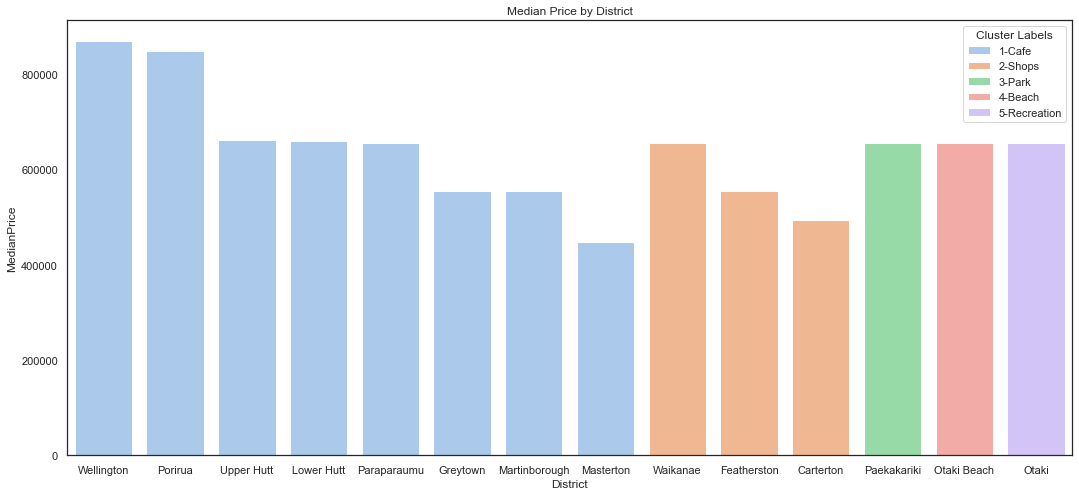

In [27]:
# Plot Median prices
sns.set(rc={'figure.figsize':(18,8)})
sns.set_style(style='white')
plt.title('Median Price by District')
sns.barplot(x='District', y='MedianPrice', hue='Cluster Labels', data=wellington_comp, palette='pastel', dodge=False)

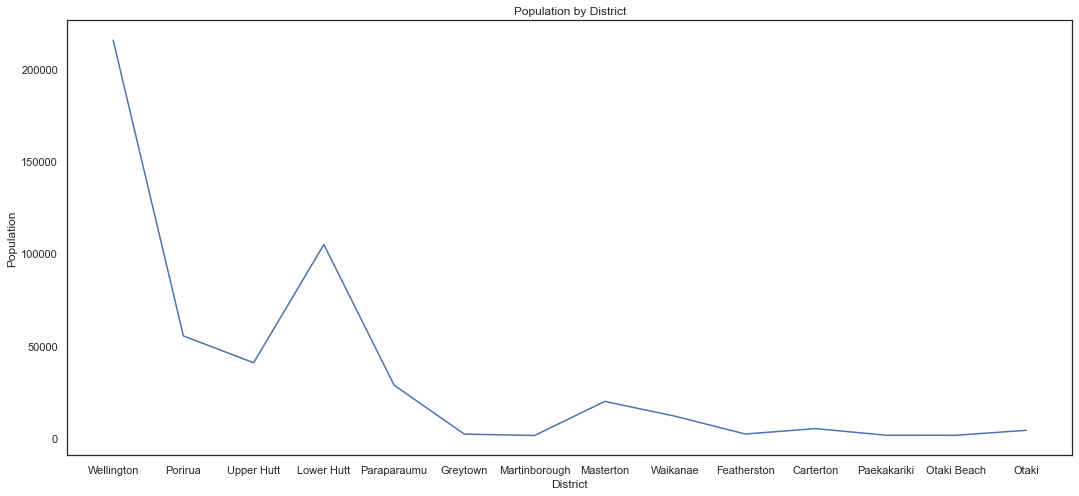

In [28]:
# Plot population
plt.title('Population by District')
sns.lineplot(x='District', y='Population', data=wellington_comp, sort=False)

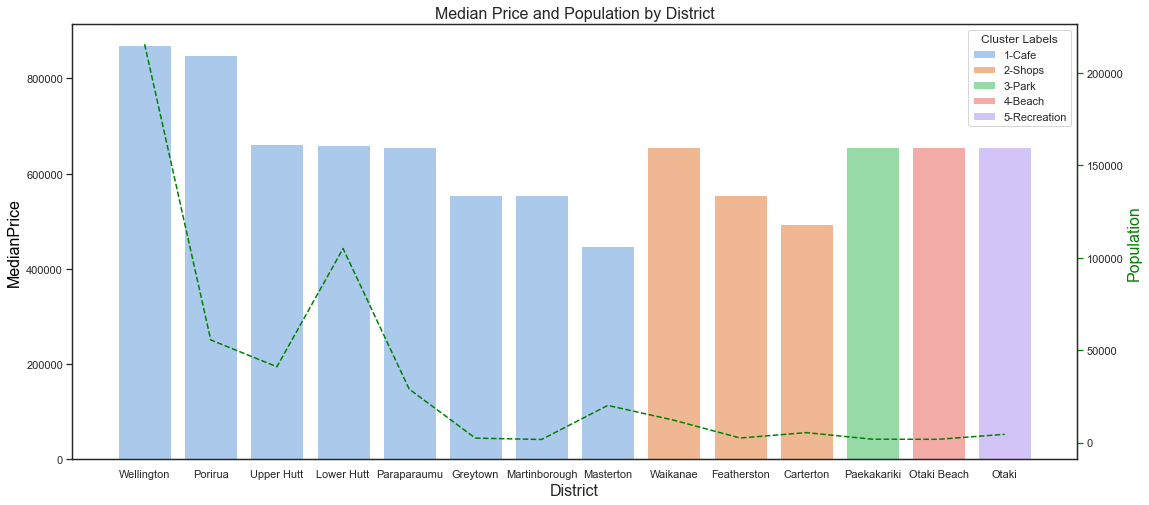

In [29]:
# Merge plots

fig, ax1 = plt.subplots(figsize=(18,8))
color = 'black'
ax1.set_title('Median Price and Population by District', fontsize=16)
ax1.set_xlabel('District', fontsize=16)
ax1.set_ylabel('Median Price', fontsize=16, color=color)
ax2 = sns.barplot(x='District', y='MedianPrice', hue='Cluster Labels', data=wellington_comp, palette='pastel', dodge=False)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'green'
ax2.set_ylabel('Population', fontsize=16, color=color)
ax2 = sns.lineplot(x='District', y='Population', data = wellington_comp, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
ax2.lines[0].set_linestyle("--")
plt.show()

## IV. Results
The final plot above shows three very important information: 
* What is the median housing price per district
* What is the population per district
* Which districts are similar in terms of nearby venues

Based on the population distribution, people in Wellington generally live in neighborhoods categorized under the "Cafe" Cluster (Wellington, Lower Hutt, Porirua, etc.), followed by the "Shops" Cluster (Waikanae, Featherston, Carterton). For each cluster, the median housing prices are directly correlated to the population. It is interesting to note that despite several neighborhoods having very similar nearby venues, the variances in the population and median housing prices are quite large. 

## V. Discussion
There is no "best" or "right" answer on where to move to -- it all depends on a person's preference and willingness to accept certain tradeoffs. 

As an example, Wellington district is clearly the hub, being the most populated district in Wellington, and as well as having the most expensive median housing prices. If Wellington district is too crowded already, then Porirua is also an option. In terms of housing prices, Porirua is a close second, but its population is just around a quarter compared to that of Wellington District's. 

If you are looking to relocate to Wellington District due to its nearby venues but find its housing prices too high, then Greytown, Martinborough, and Masterton are good alternatives, as they belong to the same cluster but have significantly lower median housing prices. 

If you find the average Wellington District's housing prices acceptable, but want a more laid back and less crowded setting and with more parks and recreational spaces, then Paekakariki and Otaki are perfect alternatives. 

## VI. Conclusion
For someone who wants to move into Wellington, there are certainly a lot of options, each with its unique setting and attributes to offer. From the analysis above, we have shown that one need not live in a highly populated or extremely expensive district just to enjoy nearby venues of interest. It all depends on the person's preference and willingness to accept certain tradeoffs. 

### Future Expectation:
* **Features**: The analysis above only uses a limited set of variables in identifying similar neighborhoods. One can add more variables other than nearby venues to make the comparison more robust.
* **Geographical Scope**: The analysis is only limited to Wellington, the capital of New Zealand. Once can extend this analysis to cover other cities and regions in the country for more options. 